## ELETTRA-25: ID model fit & compensation (tunes)

In [1]:
# In this example an ID model is fitted only from measured tunes (any other set can be used)
# In principal, given a model to be fitted and a measured target vector, any optimizer can be employed
# The fitted model is obtained using response matrix (model jacobian)
# Using the fitted model, corrections are obtained and applied to initial model
# Note, this doesn't require actual measurements and can use any optimization loop
# Only when the final corrections are computed and employed, the measurements can be performed to assert the correction quality

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

from model.command.wrapper import Wrapper
from model.command.wrapper import forward
from model.command.wrapper import inverse
from model.command.wrapper import normalize

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Merge drifts

ring.merge()

# Change lattice start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice lattice

ring.splice()

# Describe

ring.describe

{'BPM': 168, 'Drift': 708, 'Dipole': 156, 'Quadrupole': 360, 'Marker': 12}

In [6]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

In [7]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx, etapx, etaqy, etapy = dispersion(ring, orbit, [], limit=1)

In [8]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

In [9]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

In [10]:
# Compute coupling

c = coupling(ring, [])

In [11]:
# Quadrupole names for global tune correction

QF = [f'QF_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]
QD = [f'QD_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]

In [12]:
# Several local knobs can be used to correct ID effects

# Normal quadrupole correctors

nkn = ['OCT_S01_02', 'QF_S01_02', 'QD_S01_02', 'QD_S01_03', 'QF_S01_03', 'OCT_S01_03']

# Skew quadrupole correctors

nks = ['SD_S01_05', 'SH_S01_02', 'SH_S01_03', 'SD_S01_06']

In [13]:
# Define knobs to magnets mixing matrices (symmetric correction)

Sn = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]], dtype=dtype)

print(Sn)
print()

Ss = torch.tensor([[+1.0, 0.0], [0.0, +1.0], [0.0, -1.0], [-1.0, 0.0]], dtype=dtype)

print(Ss)
print()

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=torch.float64)

tensor([[ 1.,  0.],
        [ 0.,  1.],
        [ 0., -1.],
        [-1.,  0.]], dtype=torch.float64)



In [14]:
# Define ID model
# Note, only the flattened triangular part of the A and B matrices will be passed

A = torch.tensor([[-0.03484222052711237, 1.0272120741819959E-7, -4.698931299341201E-9, 0.0015923185492594811],
                  [1.0272120579834892E-7, -0.046082787920135176, 0.0017792061173117564, 3.3551298301095784E-8],
                  [-4.6989312853101E-9, 0.0017792061173117072, 0.056853750760983084, -1.5929605363332683E-7],
                  [0.0015923185492594336, 3.3551298348653296E-8, -1.5929605261642905E-7, 0.08311631737263032]], dtype=dtype)

B = torch.tensor([[0.03649353186115209, 0.0015448347221877217, 0.00002719892025520868, -0.0033681183134964482],
                  [0.0015448347221877217, 0.13683886657005795, -0.0033198692682377406, 0.00006140578258682469],
                  [0.00002719892025520868, -0.0033198692682377406, -0.05260095308967722, 0.005019907688182885],
                  [-0.0033681183134964482, 0.00006140578258682469, 0.005019907688182885, -0.2531573249456863]], dtype=dtype)

A = A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist()
B = B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist()

# Empty ID

X = Matrix('X', length=0.0)

# If A and/or B matrix elements are not passed, ID acts like an identity element

state = torch.tensor(4*[0.0], dtype=dtype)
print(torch.func.jacrev(X)(state))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)


In [15]:
# Insert empty ID into the existing lattice
# This will replace the target marker

error = ring.clone()
error.flatten()
error.insert(X, 'MLL_S01', position=0.0)
error.splice()

# Describe

error.describe

{'BPM': 168,
 'Drift': 708,
 'Dipole': 156,
 'Quadrupole': 360,
 'Matrix': 1,
 'Marker': 11}

In [16]:
# Compute ID response matrix

def observable(knobs):
    a11, a12, a13, a14, a22, a23, a24, a33, a34, a44 = knobs.reshape(-1, 1)
    groups = (
        ('a11', None, ['X'], None),
        ('a12', None, ['X'], None),
        ('a13', None, ['X'], None),
        ('a14', None, ['X'], None),
        ('a22', None, ['X'], None),
        ('a23', None, ['X'], None),
        ('a24', None, ['X'], None),
        ('a33', None, ['X'], None),
        ('a34', None, ['X'], None),
        ('a44', None, ['X'], None)
    )
    return tune(error, [a11, a12, a13, a14, a22, a23, a24, a33, a34, a44], *groups, matched=True)

knobs = torch.tensor(10*[0.0], dtype=dtype)
print((matrix := torch.func.jacfwd(observable)(knobs)).shape)

torch.Size([2, 10])


In [17]:
# Compute responce matrix rank
# Note, the responce matrix rank is now a full in contrast to the case without coupling

print(torch.linalg.matrix_rank(matrix))

tensor(2)


In [18]:
# Activate ID

X.A = A
X.B = B

In [19]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(error, [], matched=True, limit=1)

In [20]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(error, orbit, [], limit=1)

In [21]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(error, [], matched=True, advance=True, full=False).T

In [22]:
# Compute phase advances

mux_id, muy_id = advance(error, [], alignment=False, matched=True).T

In [23]:
# Compute coupling

c_id = coupling(error, [])

In [24]:
# Tune shifts

print((nux - nux_id))
print((nuy - nuy_id))

tensor(0.0260, dtype=torch.float64)
tensor(-0.0114, dtype=torch.float64)


In [25]:
# Coupling (minimal tune distance)

print(c)
print(c_id)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)


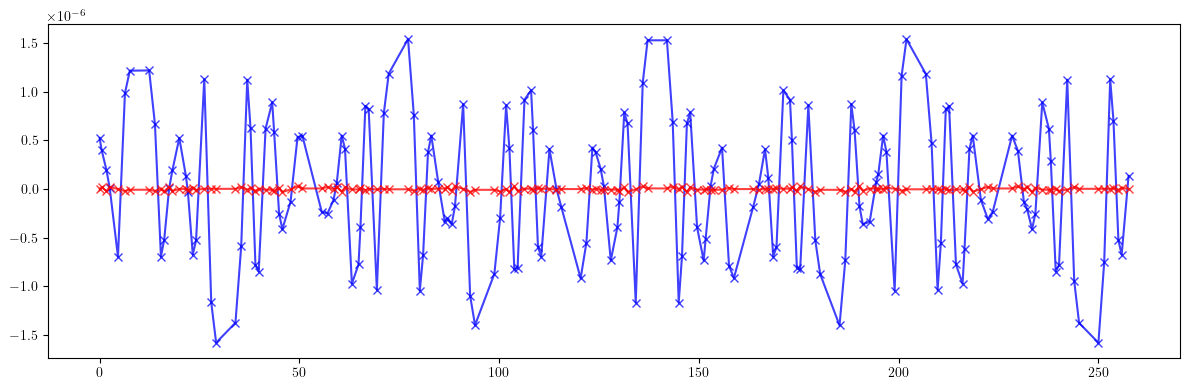

In [26]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

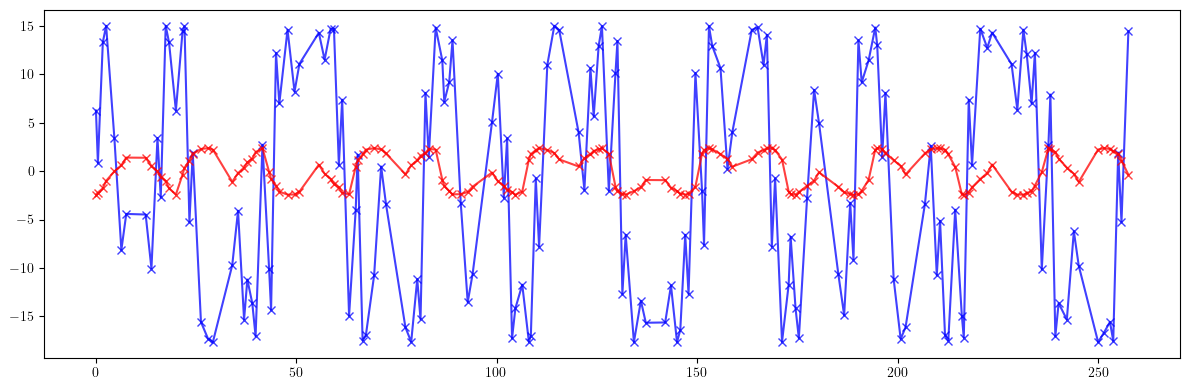

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)


In [27]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())

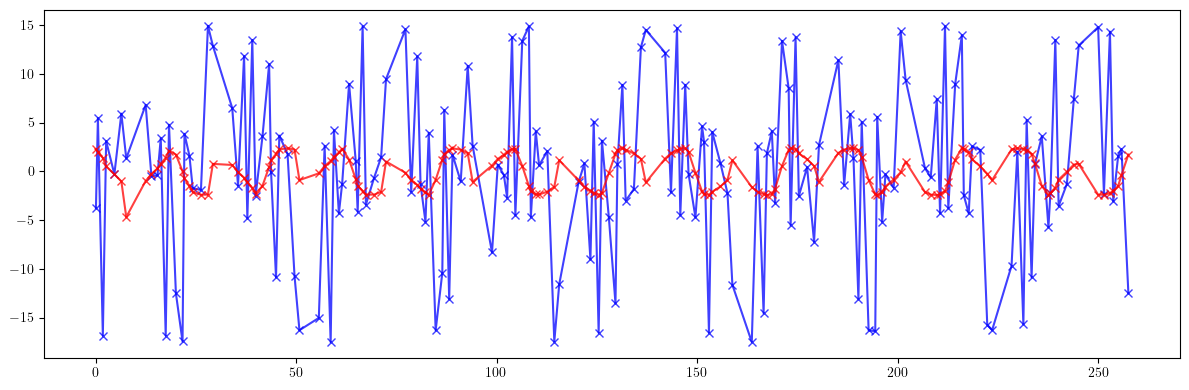

tensor(8.7941, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64)


In [28]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())

In [29]:
# Set observable vector (with ID)

target = tune(error, [], matched=True, limit=1)

In [30]:
# Create a ring with ID to be fitted

X = Matrix('X')

model = ring.clone()
model.flatten()
model.insert(X, 'MLL_S01', position=0.0)
model.splice()

In [31]:
# Set parametric observalbe

def observable(knobs):
    a11, a12, a13, a14, a22, a23, a24, a33, a34, a44 = knobs.reshape(-1, 1)
    groups = (
        ('a11', None, ['X'], None),
        ('a12', None, ['X'], None),
        ('a13', None, ['X'], None),
        ('a14', None, ['X'], None),
        ('a22', None, ['X'], None),
        ('a23', None, ['X'], None),
        ('a24', None, ['X'], None),
        ('a33', None, ['X'], None),
        ('a34', None, ['X'], None),
        ('a44', None, ['X'], None)
    )
    return tune(model, [a11, a12, a13, a14, a22, a23, a24, a33, a34, a44], *groups, matched=True)

In [32]:
# Error

knobs = torch.tensor(10*[0.0], dtype=dtype)
print(((observable(knobs) - target)**2).sum())

tensor(0.0008, dtype=torch.float64)


In [33]:
# Optimization loop

# Responce matrix (jacobian)

M = matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

knobs = torch.tensor(10*[0.0], dtype=dtype)

# Regularizaton

factor = 0.01

# Normal matrix

N = M.T @ M

# Regularized system

R = N + factor**2*torch.eye(len(N), dtype=dtype)

# Correction loop

for _ in range(16):
    value = observable(knobs)
    residual = target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(R, M.T @ residual, driver="gels").solution
    knobs += lr*delta
    print(((value - target)**2).sum())
print()

tensor(0.0008, dtype=torch.float64)
tensor(5.5082e-05, dtype=torch.float64)
tensor(4.1149e-06, dtype=torch.float64)
tensor(3.1288e-07, dtype=torch.float64)
tensor(2.3909e-08, dtype=torch.float64)
tensor(1.8304e-09, dtype=torch.float64)
tensor(1.4026e-10, dtype=torch.float64)
tensor(1.0756e-11, dtype=torch.float64)
tensor(8.2530e-13, dtype=torch.float64)
tensor(6.3359e-14, dtype=torch.float64)
tensor(4.8666e-15, dtype=torch.float64)
tensor(3.7399e-16, dtype=torch.float64)
tensor(2.8752e-17, dtype=torch.float64)
tensor(2.2114e-18, dtype=torch.float64)
tensor(1.7015e-19, dtype=torch.float64)
tensor(1.3097e-20, dtype=torch.float64)



In [34]:
# Compare fitted knobs

print((torch.tensor(A, dtype=dtype) - 0.0*knobs).norm())
print((torch.tensor(A, dtype=dtype) - 1.0*knobs).norm())

tensor(0.1161, dtype=torch.float64)
tensor(0.0739, dtype=torch.float64)


In [35]:
# Set fitted ID

X.A = knobs

In [36]:
# Compute tunes (fractional part)

nux_model, nuy_model = tune(model, [], matched=True, limit=1)

In [37]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_model, etapx_model, etaqy_model, etapy_model = dispersion(model, orbit, [], limit=1)

In [38]:
# Compute twiss parameters

ax_model, bx_model, ay_model, by_model = twiss(model, [], matched=True, advance=True, full=False).T

In [39]:
# Compute phase advances

mux_model, muy_model = advance(model, [], alignment=False, matched=True).T

In [40]:
# Compute coupling

c_model = coupling(model, [])

In [41]:
# Tune shifts

print((nux_id - nux_model))
print((nuy_id - nuy_model))

tensor(-3.0878e-11, dtype=torch.float64)
tensor(7.4143e-12, dtype=torch.float64)


In [42]:
# Coupling (minimal tune distance)

print(c_id)
print(c_model)

tensor(0.0004, dtype=torch.float64)
tensor(0., dtype=torch.float64)


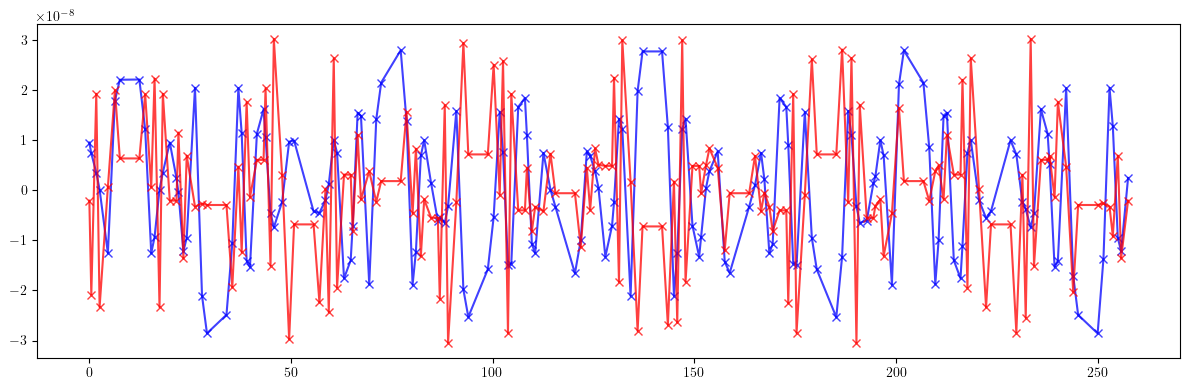

In [43]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx_id - etaqx_model).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy_id - etaqy_model).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

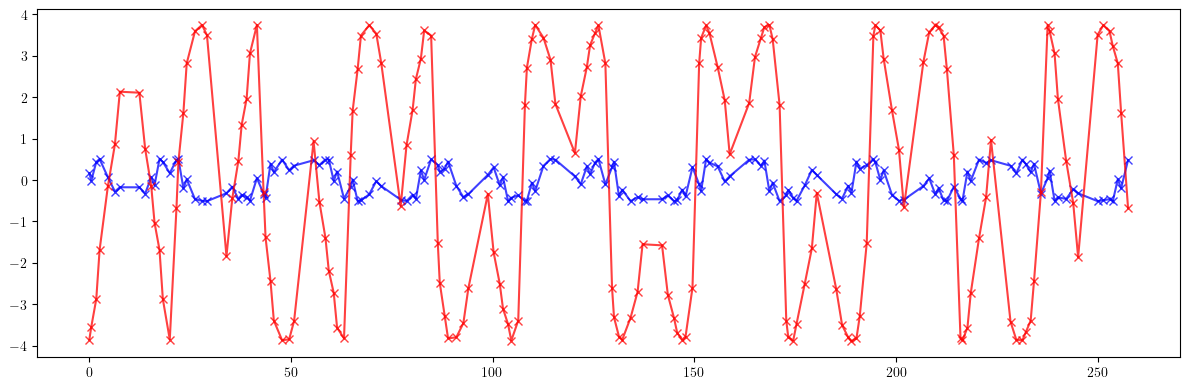

tensor(0.3611, dtype=torch.float64)
tensor(2.8426, dtype=torch.float64)


In [44]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx_id - bx_model)/bx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by_id - by_model)/by_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx_id - bx_model)/bx_id)**2).mean().sqrt())
print(100*(((by_id - by_model)/by_id)**2).mean().sqrt())

In [45]:
# Global tune responce matrix

def global_observable(knobs):
    kf, kd = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd])
    return tune(ring, [kn], ('kn', None, QF + QD, None), matched=True, limit=1)

knobs = torch.tensor([0.0, 0.0], dtype=dtype)
global_target = global_observable(knobs)
global_matrix = torch.func.jacfwd(global_observable)(knobs)

print(global_target)
print(global_matrix)

tensor([0.2994, 0.1608], dtype=torch.float64)
tensor([[ 5.8543,  2.0964],
        [-2.9918, -1.2602]], dtype=torch.float64)


In [46]:
# Define twiss observable

def observable_twiss(kn, ks):
    return twiss(ring, 
                 [kn, ks],
                 ('kn', None, nkn, None),
                 ('ks', None, nks, None),
                 matched=True, 
                 advance=True,
                 full=False, 
                 convert=False)

In [47]:
# Define dispersion observable

def observable_dispersion(kn, ks):
    orbit = torch.tensor(4*[0.0], dtype=dtype)
    etax, _, etay, _ = dispersion(ring, 
                                  orbit,
                                  [kn, ks],
                                  ('kn', None, nkn, None),
                                  ('ks', None, nks, None))
    return torch.stack([etax, etay]).T

In [48]:
# Construct full target observable vector and corresponding responce matrix

def observable(knobs):
    kn, ks = torch.split(knobs, [3, 2])
    kn = Sn @ kn
    ks = Ss @ ks
    wolski = observable_twiss(kn, ks)
    etas = observable_dispersion(kn, ks)
    return torch.cat([wolski.flatten(), etas.flatten()])

knobs = torch.tensor((3 + 2)*[0.0], dtype=dtype)
print((target := observable(knobs)).shape)
print((matrix := torch.func.jacfwd(observable)(knobs)).shape)

torch.Size([5712])
torch.Size([5712, 5])


In [49]:
# Define parametric observable vector

def global_observable(knobs):
    kf, kd = knobs
    kn = torch.stack(len(QF)*[kf] + len(QD)*[kd])
    return tune(model, [kn], ('kn', None, QF + QD, None), matched=True, limit=1)


def observable_twiss(kn, ks):
    return twiss(model, [kn, ks], ('kn', None, nkn, None), ('ks', None, nks, None), matched=True, advance=True, full=False, convert=False)


def observable_dispersion(kn, ks):
    orbit = torch.tensor(4*[0.0], dtype=dtype)
    etax, _, etay, _ = dispersion(model, 
                                  orbit,
                                  [kn, ks],
                                  ('kn', None, nkn, None),
                                  ('ks', None, nks, None))
    return torch.stack([etax, etay]).T


def observable(knobs):
    kn, ks = torch.split(knobs, [3, 2])
    kn = Sn @ kn
    ks = Ss @ ks  
    wolski = observable_twiss(kn, ks)
    etas = observable_dispersion(kn, ks)
    return torch.cat([wolski.flatten(), etas.flatten()])

In [50]:
# Check the residual vector norm

global_knobs = torch.tensor(2*[0.0], dtype=dtype)
knobs = torch.tensor((3 + 2)*[0.0], dtype=dtype)

print(((global_observable(global_knobs) - global_target)**2).sum())
print(((observable(knobs) - target)**2).sum())

tensor(0.0008, dtype=torch.float64)
tensor(290.5871, dtype=torch.float64)


In [51]:
# Optimization loop (local)

# Responce matrix (jacobian)

M = matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

knobs = torch.tensor((3 + 2)*[0.0], dtype=dtype)

# Correction loop

for _ in range(8):
    value = observable(knobs)
    residual = target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    knobs += lr*delta
    print(((value - target)**2).sum())
print()

tensor(290.5871, dtype=torch.float64)
tensor(16.7087, dtype=torch.float64)
tensor(1.5747, dtype=torch.float64)
tensor(0.4815, dtype=torch.float64)
tensor(0.4093, dtype=torch.float64)
tensor(0.4047, dtype=torch.float64)
tensor(0.4044, dtype=torch.float64)
tensor(0.4044, dtype=torch.float64)



In [52]:
# Apply final corrections

kn, ks = torch.split(knobs, [3, 2])

kn = Sn @ kn
ks = Ss @ ks

model.flatten()

for name, knob in zip(nkn, kn):
    model[name].kn = (model[name].kn + knob).item()
    
for name, knob in zip(nks, ks):
    model[name].ks = (model[name].ks + knob).item()
    
model.splice()

In [53]:
# Optimization loop (global)

# Responce matrix (jacobian)

M = global_matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

global_knobs = torch.tensor(2*[0.0], dtype=dtype)

# Correction loop

for _ in range(4):
    value = global_observable(global_knobs)
    residual = global_target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    global_knobs += lr*delta
    print(((value - global_target)**2).sum())
print()

tensor(0.0003, dtype=torch.float64)
tensor(2.7515e-05, dtype=torch.float64)
tensor(2.7924e-06, dtype=torch.float64)
tensor(3.1560e-07, dtype=torch.float64)



In [54]:
# Apply final corrections

kd, kf = global_knobs

model.flatten()

for name in QF:
    model[name].kn = (model[name].kn + kd).item()

for name in QD:
    model[name].kn = (model[name].kn + kf).item()
    
model.splice()

In [55]:
# Correction

QF = [f'QF_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]
QD = [f'QD_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]

nkn = ['OCT_S01_02', 'QF_S01_02', 'QD_S01_02', 'QD_S01_03', 'QF_S01_03', 'OCT_S01_03']
nks = ['SD_S01_05', 'SH_S01_02', 'SH_S01_03', 'SD_S01_06']

model.flatten()

knf = {name: model[name].kn.item() for name in nkn}
ksf = {name: model[name].ks.item() for name in nks}
kff = {name: model[name].kn.item() for name in QF}
kdf = {name: model[name].kn.item() for name in QD}

model.splice()

error.flatten()

for name, knob in knf.items():
    error[name].kn = knob
    
for name, knob in ksf.items():
    error[name].ks = knob

for name, knob in kff.items():
    error[name].kn = knob
    
for name, knob in kdf.items():
    error[name].kn = knob

error.splice()

In [56]:
# Compute tunes (fractional part)

nux_result, nuy_result = tune(error, [], matched=True, limit=1)

In [57]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(error, orbit, [], limit=1)

In [58]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(error, [], matched=True, advance=True, full=False).T

In [59]:
# Compute phase advances

mux_result, muy_result = advance(error, [], alignment=False, matched=True).T

In [60]:
# Compute coupling

c_result = coupling(error, [])

In [61]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())
print()

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)

tensor(8.3951e-05, dtype=torch.float64)
tensor(4.8422e-05, dtype=torch.float64)



In [62]:
# Coupling (minimal tune distance)

print(c)
print(c_id)
print(c_result)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)


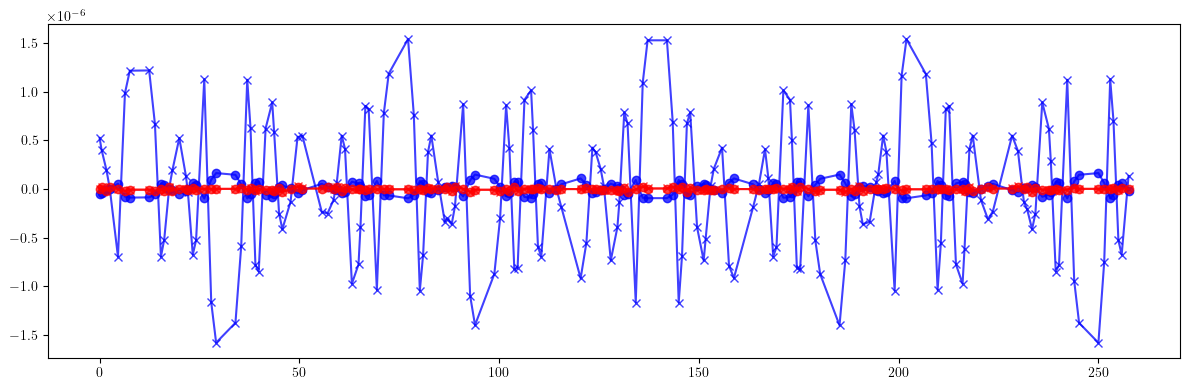

In [63]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

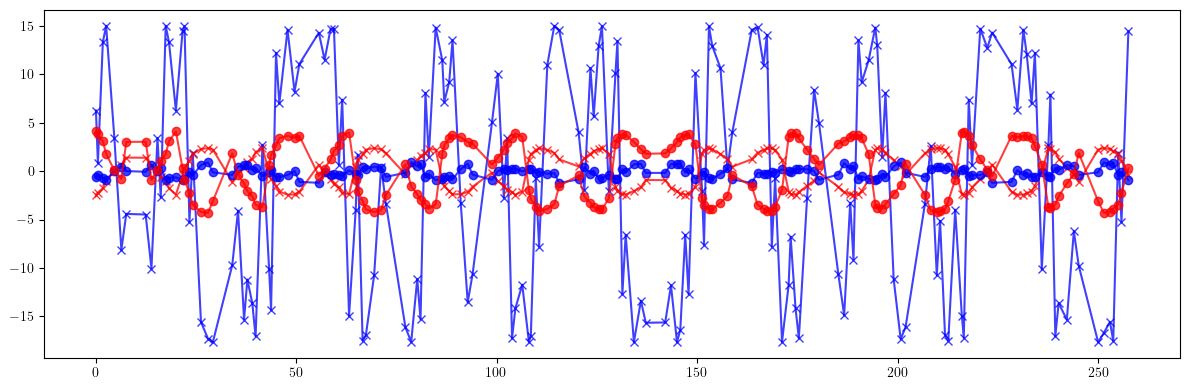

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(0.5448, dtype=torch.float64)
tensor(2.9926, dtype=torch.float64)



In [64]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

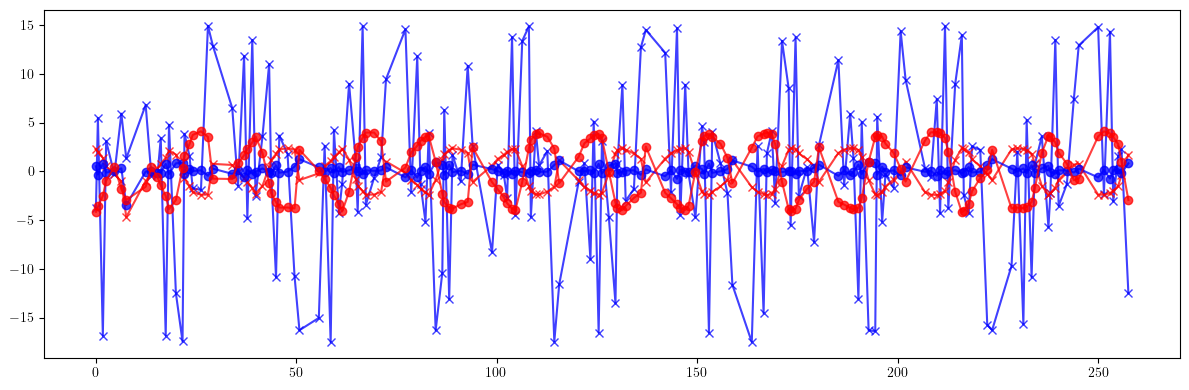

tensor(8.7941, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64)

tensor(0.4850, dtype=torch.float64)
tensor(2.9085, dtype=torch.float64)



In [65]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_result)/mux).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_result)/muy).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())
print()

print(100*(((mux - mux_result)/mux)**2).mean().sqrt())
print(100*(((muy - muy_result)/muy)**2).mean().sqrt())
print()

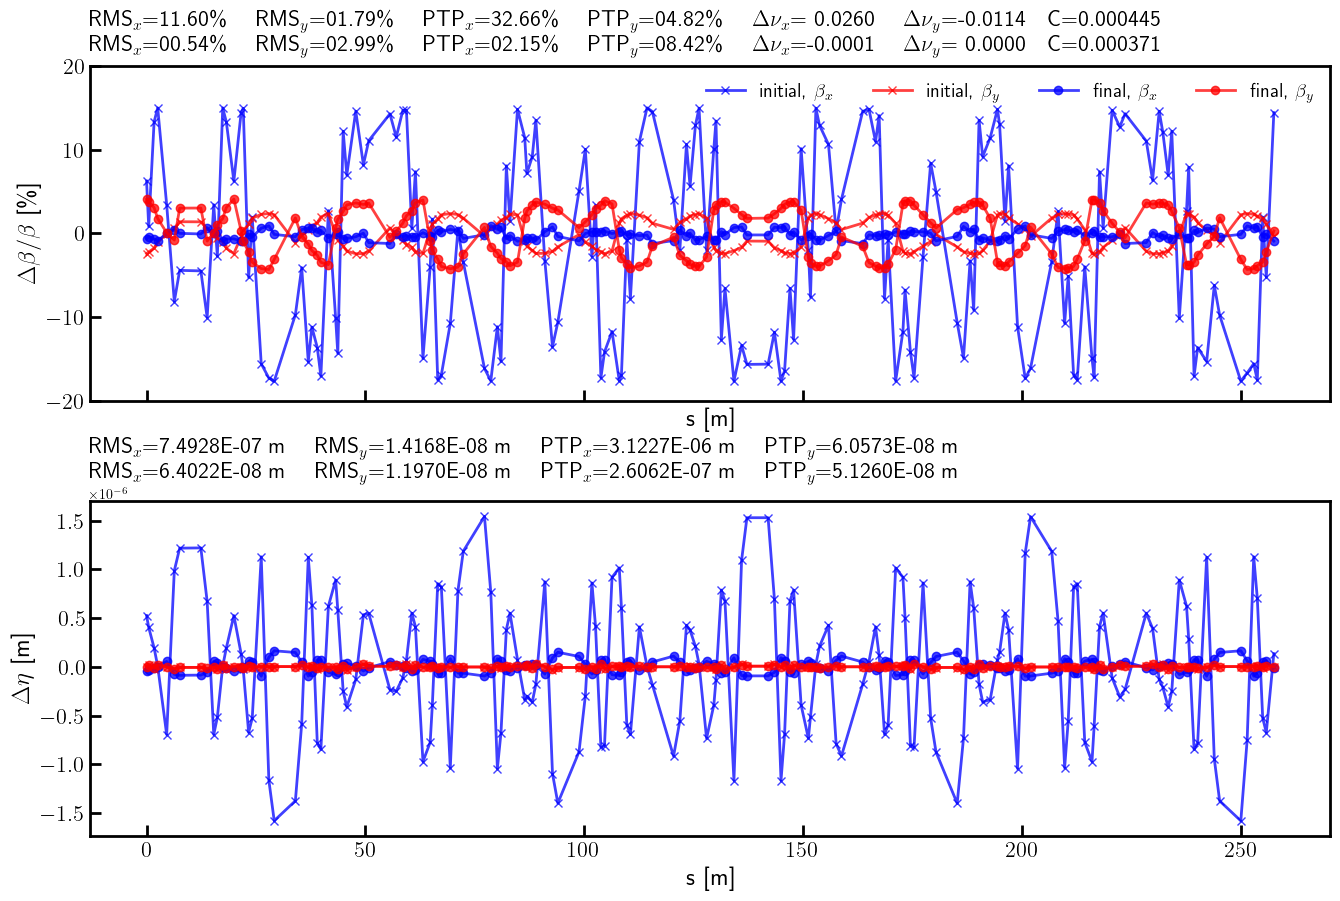

In [66]:
# Beta-beating and dispersion

bx_ref_bb = 100.0*(bx - bx_id)    / bx
by_ref_bb = 100.0*(by - by_id)    / by
bx_res_bb = 100.0*(bx - bx_result)/ bx
by_res_bb = 100.0*(by - by_result)/ by

def rms(x):
    return (x**2).mean().sqrt()

rms_x_ref = rms(bx_ref_bb).item()
ptp_x_ref = (bx_ref_bb.max() - bx_ref_bb.min()).item()
rms_y_ref = rms(by_ref_bb).item()
ptp_y_ref = (by_ref_bb.max() - by_ref_bb.min()).item()

rms_x_res = rms(bx_res_bb).item()
ptp_x_res = (bx_res_bb.max() - bx_res_bb.min()).item()
rms_y_res = rms(by_res_bb).item()
ptp_y_res = (by_res_bb.max() - by_res_bb.min()).item()

s = ring.locations().cpu().numpy()
bx_ref_np = bx_ref_bb.cpu().numpy()
by_ref_np = by_ref_bb.cpu().numpy()
bx_res_np = bx_res_bb.cpu().numpy()
by_res_np = by_res_bb.cpu().numpy()

etax_ref = etaqx - etaqx_id
etay_ref = etaqy - etaqy_id
etax_res = etaqx - etaqx_result
etay_res = etaqy - etaqy_result

rms_etax_ref = rms(etax_ref).item()
ptp_etax_ref = (etax_ref.max() - etax_ref.min()).item()
rms_etay_ref = rms(etay_ref).item()
ptp_etay_ref = (etay_ref.max() - etay_ref.min()).item()

rms_etax_res = rms(etax_res).item()
ptp_etax_res = (etax_res.max() - etax_res.min()).item()
rms_etay_res = rms(etay_res).item()
ptp_etay_res = (etay_res.max() - etay_res.min()).item()

etax_ref_np = etax_ref.cpu().numpy()
etay_ref_np = etay_ref.cpu().numpy()
etax_res_np = etax_res.cpu().numpy()
etay_res_np = etay_res.cpu().numpy()

fig, (ax, ay) = plt.subplots(
    2, 1, figsize=(16, 10),
    sharex=True,
    gridspec_kw={'hspace': 0.3}
)

ax.errorbar(s, bx_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'initial, $\beta_x$')
ax.errorbar(s, by_ref_np, fmt='-', marker='x', color='red',  alpha=0.75, lw=2.0, label=r'initial, $\beta_y$')
ax.errorbar(s, bx_res_np, fmt='-', marker='o', color='blue', alpha=0.75, lw=2.0, label=r'final, $\beta_x$')
ax.errorbar(s, by_res_np, fmt='-', marker='o', color='red',  alpha=0.75, lw=2.0, label=r'final, $\beta_y$')
ax.set_xlabel('s [m]', fontsize=18)
ax.set_ylabel(r'$\Delta \beta / \beta$ [\%]', fontsize=18)
ax.tick_params(width=2, labelsize=16)
ax.tick_params(axis='x', length=8, direction='in')
ax.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_x_ref:05.2f}\% \quad RMS$_y$={rms_y_ref:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_ref:05.2f}\% \quad PTP$_y$={ptp_y_ref:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_id)}{(nux - nux_id).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_id)}{(nuy - nuy_id).abs().item():.4f}'
    rf'\quad C={c_id.item():.6f}'
)
ax.text(0.0, 1.10, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_x_res:05.2f}\% \quad RMS$_y$={rms_y_res:05.2f}\% \quad '
    rf'PTP$_x$={ptp_x_res:05.2f}\% \quad PTP$_y$={ptp_y_res:05.2f}\% \quad '
    rf'$\Delta \nu_x$={(lambda x: '-' if x < 0 else '~')(nux - nux_result)}{(nux - nux_result).abs().item():.4f} \quad $\Delta \nu_y$={(lambda x: '-' if x < 0 else '~')(nuy - nuy_result)}{(nuy - nuy_result).abs().item():.4f}'
    rf'\quad C={c_result.item():.6f}'
)
ax.text(0.0, 1.025, title, transform=ax.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=4)
ax.set_ylim(-20, 20)

ay.errorbar(s, etax_ref_np, fmt='-', marker='x', color='blue', alpha=0.75, lw=2.0, label=r'initial, $\eta_x$')
ay.errorbar(s, etay_ref_np, fmt='-', marker='x', color='red', alpha=0.75, lw=2.0, label=r'initial, $\eta_y$')
ay.errorbar(s, etax_res_np, fmt='-', marker='o', color='blue',alpha=0.75, lw=2.0, label=r'final, $\eta_x$')
ay.errorbar(s, etay_res_np, fmt='-', marker='o', color='red', alpha=0.75, lw=2.0, label=r'final, $\eta_y$')
ay.set_xlabel('s [m]', fontsize=18)
ay.set_ylabel(r'$\Delta \eta$ [m]', fontsize=18)
ay.tick_params(width=2, labelsize=16)
ay.tick_params(axis='x', length=8, direction='in')
ay.tick_params(axis='y', length=8, direction='in')
title = (
    rf'RMS$_x$={rms_etax_ref:.4E} m \quad RMS$_y$={rms_etay_ref:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_ref:.4E} m \quad PTP$_y$={ptp_etay_ref:.4E} m  \quad '
)
ay.text(0.0, 1.125, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')
title = (
    rf'RMS$_x$={rms_etax_res:.4E} m  \quad RMS$_y$={rms_etay_res:.4E} m  \quad '
    rf'PTP$_x$={ptp_etax_res:.4E} m  \quad PTP$_y$={ptp_etay_res:.4E} m  \quad '
)
ay.text(0.0, 1.05, title, transform=ay.transAxes, ha='left', va='bottom', fontsize=16, fontfamily='monospace')

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)

plt.show()

In [67]:
# Knobs

QF = [f'QF_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]
QD = [f'QD_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]

nkn = ['OCT_S01_02', 'QF_S01_02', 'QD_S01_02', 'QD_S01_03', 'QF_S01_03', 'OCT_S01_03']
nks = ['SD_S01_05', 'SH_S01_02', 'SH_S01_03', 'SD_S01_06']

ring.flatten()

kni = {name: ring[name].kn.item() for name in nkn}
ksi = {name: ring[name].ks.item() for name in nks}
kfi = {name: ring[name].kn.item() for name in QF}
kdi = {name: ring[name].kn.item() for name in QD}

error.flatten()

knf = {name: error[name].kn.item() for name in nkn}
ksf = {name: error[name].ks.item() for name in nks}
kff = {name: error[name].kn.item() for name in QF}
kdf = {name: error[name].kn.item() for name in QD}

print(dkf := [(kff[name] - kfi[name]) for name in kfi if name not in nkn])
print()

print(dkd := [(kdf[name] - kdi[name]) for name in kdi if name not in nkn])
print()

dkf, *_ = dkf
dkd, *_ = dkd

dk = {'DKF': dkf, 'DKD': dkd}

[-0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136, -0.04130517965319136]

[0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907, 0.11295768858628907]



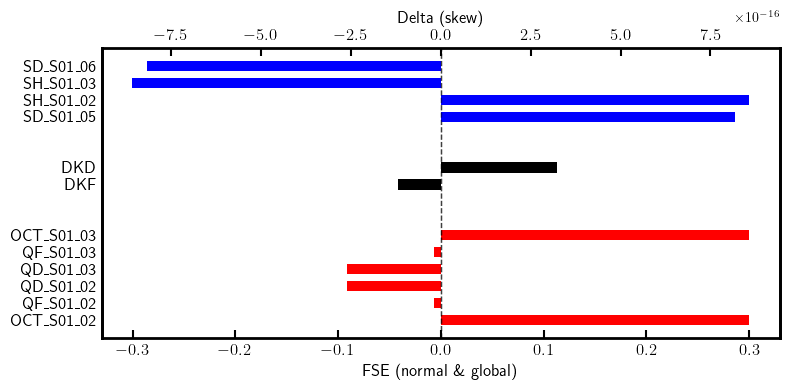

In [68]:
import numpy as np

dkn = np.array([knf[i]/kni[i] - 1 for i in kni])
dks = np.array([ksf[i] - ksi[i] for i in ksi])

n_kn = len(dkn)
n_ks = len(dks)
n_dk = len(dk)

y_kn = np.arange(n_kn)
y_dk = np.arange(n_dk) + n_kn + 2*1
y_ks = np.arange(n_ks) + n_kn + n_dk + 2*2

fig, ax = plt.subplots(figsize=(8, 4))
ay = ax.twiny()

bar_kn = ax.barh(y_kn, dkn, height=0.6, alpha=1, label=r'normal', color='red')
bar_dk = ax.barh(y_dk, list(dk.values()), height=0.6, alpha=1, label=r'global', color='black')
bar_ks = ay.barh(y_ks, dks, height=0.6, alpha=1, label=r'skew', color='blue')

yticks = np.concatenate([y_kn, y_dk, y_ks])
yticklabels = [*kni.keys()] + [*dk.keys()] + [*ksi.keys()]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=12)
ay.set_ylim(ax.get_ylim())
ax.axvline(0.0, color='black', linewidth=1.0, linestyle='--', alpha=0.5)
ay.axvline(0.0, color='black', linewidth=1.0, linestyle='--', alpha=0.5)
xmax = max(np.max(np.abs(dkn)), np.max(np.abs(list(dk.values()))))
ax.set_xlim(-1.1 * xmax, 1.1 * xmax)
xmax = np.max(np.abs(dks))
ay.set_xlim(-1.1 * xmax, 1.1 * xmax)

ax.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
ax.tick_params(axis='y', length=0, width=0, labelsize=12)
ay.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=False, top=True, labelbottom=False, labeltop=True)

ax.set_xlabel(r'FSE (normal \& global)', fontsize=12)
ay.set_xlabel(r'Delta (skew)', fontsize=12)

plt.setp(ax.spines.values(), linewidth=2.0)
plt.setp(ay.spines.values(), linewidth=2.0)
ax.spines['top'].set_visible(False)
ay.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()